In [150]:
libraries = c("dplyr", "tidyverse", "magrittr", "ggpubr", "rworldmap", "MASS", "Rlab")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

theme_set(theme_bw())

In [151]:
time_0 <- as.Date("2022-04-17") ## the date of symptom onset of the initial case in the UK
time_end <- as.Date("2022-10-02") ## the end date of study period

In [152]:
## MPX incidence data (the WHO data)
path <- "../data/incidence/WHO_dashboard/"
list.files(path = path, pattern = "*csv") -> file_list
read_csv_files <- function(x){return(suppressMessages(read.csv(paste0(path, x))))}
lapply(file_list, read_csv_files) -> df_list

do.call(rbind, df_list) %>% as.data.frame() %>% dplyr::select(-c("who_region", "who_region_long")) %>% 
rename(date=reference_date, iso_code=iso3, new_cases=cases, location=country) -> df_inci
df_inci$date <- as.Date(df_inci$date)

## modifying China data (manually distinguishing Taiwan, Hong Kong, Mainland China)
df_inci %<>% mutate(iso_code=case_when(iso_code==c("CHN") & date < as.Date("2022-08-29") ~ c("TWN"),
                                       iso_code==c("CHN") & date == as.Date("2022-09-28") ~ c("TWN"),
                                       iso_code==c("CHN") & date == as.Date("2022-08-30") ~ c("HKG"),
                                       TRUE ~ iso_code),
                    location=case_when(iso_code==c("TWN") ~ c("Taiwan, Province of China"), 
                                       iso_code==c("HKG") ~ c("Hong Kong"), TRUE ~ location))

## adding missing countries with the manually collected Global.health data (by the date of repoting)
read.csv("../data/incidence/df_inci_Github.csv") -> df_global
df_global %>% filter(iso_code %in% c("ZAF", "PRY", "PRI", "MOZ", "MNE", "MTQ", "LBR", "JOR", "IRN", "GUM",
                                     "GLP", "BHR", "BEN", "BOL", "GHA", "CMR", "COG", "EGY", "GBZ", 
                                     "IND", "RUS", "MCO")) %>%
dplyr::select(Country, Date, Cases, iso_code) %>% mutate(date_type=c("Reported")) %>%
rename(location=Country, date=Date, new_cases=Cases) -> df_global
df_global$date <- as.Date(df_global$date, format="%Y-%m-%d")
rbind(df_inci, df_global) -> df_inci

## removing cases before the current global outbreak
df_inci %<>% filter(!(location==c("Singapore") & date <= as.Date("2022-05-01"))) %>%
filter(!(location==c("Brazil") & date <= as.Date("2022-05-01"))) %>%
filter(!(location==c("Czechia") & date <= as.Date("2022-05-01"))) %>%
group_by(location) %>% filter(date < time_end)

     meanlog        sdlog         sigma   
  1.861100444   0.651295117   0.178270835 
 (0.002892104) (0.002045016) (0.001540624)

[1] 7.950168

[1] 6.43081

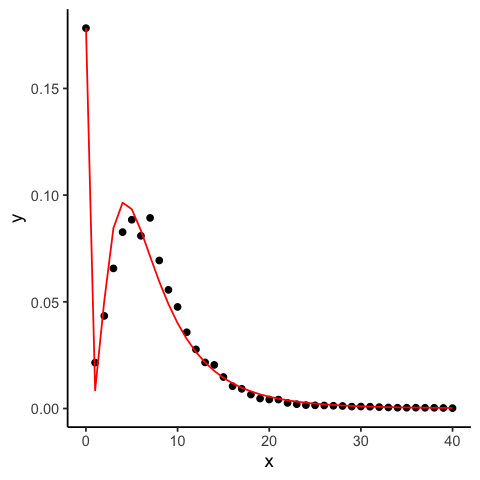

In [153]:
## estimating the mean value of the WHO reporting delay: zero-inflated lognoraml distribution
read.csv("../data/delay_WHO.csv") -> df_delay
df_delay %>% filter(reporting_delay >=0) -> df_delay_pos
rep(df_delay_pos$reporting_delay, df_delay_pos$cases) -> value_pos

dzip <- function (x, meanlog, sdlog, sigma){
    ifelse((x == 0), (dbern(1, sigma, log=FALSE)),dbern(0, sigma, log=FALSE)*dlnorm(x, meanlog, sdlog, log=FALSE))
}
(fit_zip = fitdistr(value_pos, dzip, start = list(meanlog = 1.7, sdlog=0.5, sigma = 0.3), lower = list(p = 0.00001)))

(est_mean <- exp(as.numeric(fit_zip[[1]][1]) + (1/2)*as.numeric(fit_zip[[1]][2])^2))
(est_medina <- exp(as.numeric(fit_zip[[1]][1])))

## checking the fitting
point <- as.data.frame(table(value_pos)); names(point) <- c("x","y")
point <- transform(point,x=as.numeric(as.character(x)))
point$y <- point$y/sum(point[,2])

options(repr.plot.width=4,repr.plot.height=4)
ggplot() + 
geom_point(data = point,aes(x = x,y = y)) +     
geom_line(aes(x=point[,1],y=ifelse((point[,1]==0),(dbern(1, 0.178270835)), 
                                   dbern(0, 0.178270835)*dlnorm(point[,1], 1.861100444, 0.651295117))),color="red") + 
theme_classic()

In [154]:
## back-projection with surveillance package
library(surveillance)
df_inci %>% filter(date_type %in% c("Diagnosis", "Reported")) %>% ungroup() -> df_inci_report
as.data.frame(seq(as.Date("2021-12-01"), max(df_inci$date), by=c("day"))) -> temp_cal; colnames(temp_cal) <- c("date")

unique(df_inci_report$location) -> backproj_country
backproj_list <- list()
for (i in 1:length(backproj_country)){
    df_inci_report %>% filter(location==backproj_country[i]) %>% dplyr::select(iso_code) %>% 
     unique() %>% as.character() -> iso_info
     merge(temp_cal, df_inci_report %>% filter(location==backproj_country[i]), 
           by=c("date"), all.x=TRUE) -> df_backproj
    
    ## adding extra 10 days for the stability of back-projection procedure
    as.data.frame(seq((max(df_inci$date)+1), (max(df_inci$date)+10), by=c("day"))) -> temp_lastdays
    colnames(temp_lastdays) <- c("date")
    temp_lastdays %<>% mutate(location=NA, iso_code=NA, date_type=c("Reported"), new_cases=0)
    rbind(df_backproj, temp_lastdays) %>% 
    mutate(location=backproj_country[i], iso_code=iso_info, date_type=c("Reported"),
           new_cases=case_when(is.na(new_cases)~0, TRUE~new_cases)) -> df_backproj
    df_backproj %<>% mutate(t = 1:nrow(df_backproj)) 
    
    
    ## time delay from the symptom onset to reporting
    K = nrow(df_backproj)
    report_probability = plnorm(1:K, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2])) - 
                         plnorm(1:K-1, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2]))
    report_pmf = c(0,report_probability[1:21])

    
    ## back-projecton of domestic cases
    sts = new("sts", epoch=df_backproj$t, observed=df_backproj$new_cases)
    bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_backproj$total_backproj = upperbound(sts_bp)


    ## normalizing the back-projected cases
    df_backproj$total_backproj[df_backproj$total_backproj<=0.1] <- 0

    df_backproj %>% mutate(total_normal = total_backproj/sum(total_backproj)*sum(new_cases)) %>%
    dplyr::select(-c("new_cases","total_backproj", "t")) %>% rename(new_cases=total_normal) %>% 
    mutate(date_type=c("Onset")) -> backproj_list[[i]]    
}

do.call(rbind, backproj_list) -> backproj_final

## merging the dataset with the back-projected cases
df_inci %>% filter(date_type==c("Onset")) -> temp_onset
rbind(temp_onset, backproj_final) %>%
group_by(location, date, iso_code) %>% summarise(total_new_cases=sum(new_cases)) %>% 
ungroup() %>% rename(new_cases=total_new_cases) %>% filter(new_cases > 0) -> df_inci

`summarise()` has grouped output by 'location', 'date'. You can override using
the `.groups` argument.


In [155]:
## date of the first importation
df_inci %>% arrange(date) %>% group_by(location) %>% filter(rank(date)==1) %>% 
dplyr::select(location, date) %>% rename(date_import = date) -> temp
merge(df_inci, temp, by=c("location"), all.x=TRUE) %>% arrange(location, date) -> df_inci

In [156]:
## adding dates with zero case and calculating the cumulative number of cases
as.data.frame(seq(min(df_inci$date), time_end, by="day")) -> temp_cal; colnames(temp_cal) <- c("date") 
unique(df_inci$location) -> MPX_country_list
df_inci$date <- as.Date(df_inci$date); temp_cal$date <- as.Date(temp_cal$date); 

df_inci_list <- list()
for(i in 1:length(MPX_country_list)){
    df_inci %>% filter(location==MPX_country_list[i]) -> temp_inci
    merge(temp_cal, temp_inci, by=c("date"), all.x=TRUE) -> temp_inci_all

    temp_inci_all$location[is.na(temp_inci_all$location)] <- unique(temp_inci$location)
    temp_inci_all$iso_code[is.na(temp_inci_all$iso_code)] <- unique(temp_inci$iso_code)
    temp_inci_all$new_cases[is.na(temp_inci_all$new_cases)] <- 0
    temp_inci_all$date_import[is.na(temp_inci_all$date_import)] <- unique(temp_inci$date_import)
    
    temp_inci_all %>% dplyr::select(location, iso_code, date, new_cases, date_import) %>%
    group_by(location) %>% mutate(total_cases=cumsum(new_cases)) -> df_inci_list[[i]]    
}

do.call("rbind", df_inci_list) %>% as.data.frame() %>% arrange(location, date) -> df_inci
write.csv(df_inci, "../data/incidence/df_inci_WHO.csv")

In [157]:
## MSM population
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize_Fumi.csv") -> df_MSM2

## revising the pop2022 column from df_MSM2
read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, location=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

## giving a priority to UNAIDS dashboard
merge(df_MSM1, df_MSM2, by=c("location"),all=TRUE) %>% 
dplyr::select(location, iso_code, estimate, MSM_size, region, sub_region, pop2022) %>%
mutate(prop=estimate/pop2022) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_size), 
       prop=imputed/pop2022) -> temp

## imputation of missing values
temp %>% group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_avg = mean(prop)) -> prop_avg
merge(temp, prop_avg, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_avg),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*pop2022)) -> df_MSM_imputed

## modifying Samoa data with the value from UNAIDS reports
df_MSM_imputed %>% mutate(imputed=case_when(location==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(location==c("Samoa")~MSM_size/pop2022, TRUE~prop)) -> df_MSM_imputed

write.csv(df_MSM_imputed, "../data/MSM_pop/df_MSM_imputed.csv")

In [158]:
## merging incidence data with MSM population data
merge(df_inci, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) -> df_all_inci
write.csv(df_all_inci, "../data/MSM_pop/df_all_inci_WHO_backproj.csv")

228 codes from your data successfully matched countries in the map
6 codes from your data failed to match with a country code in the map
15 codes from the map weren't represented in your data


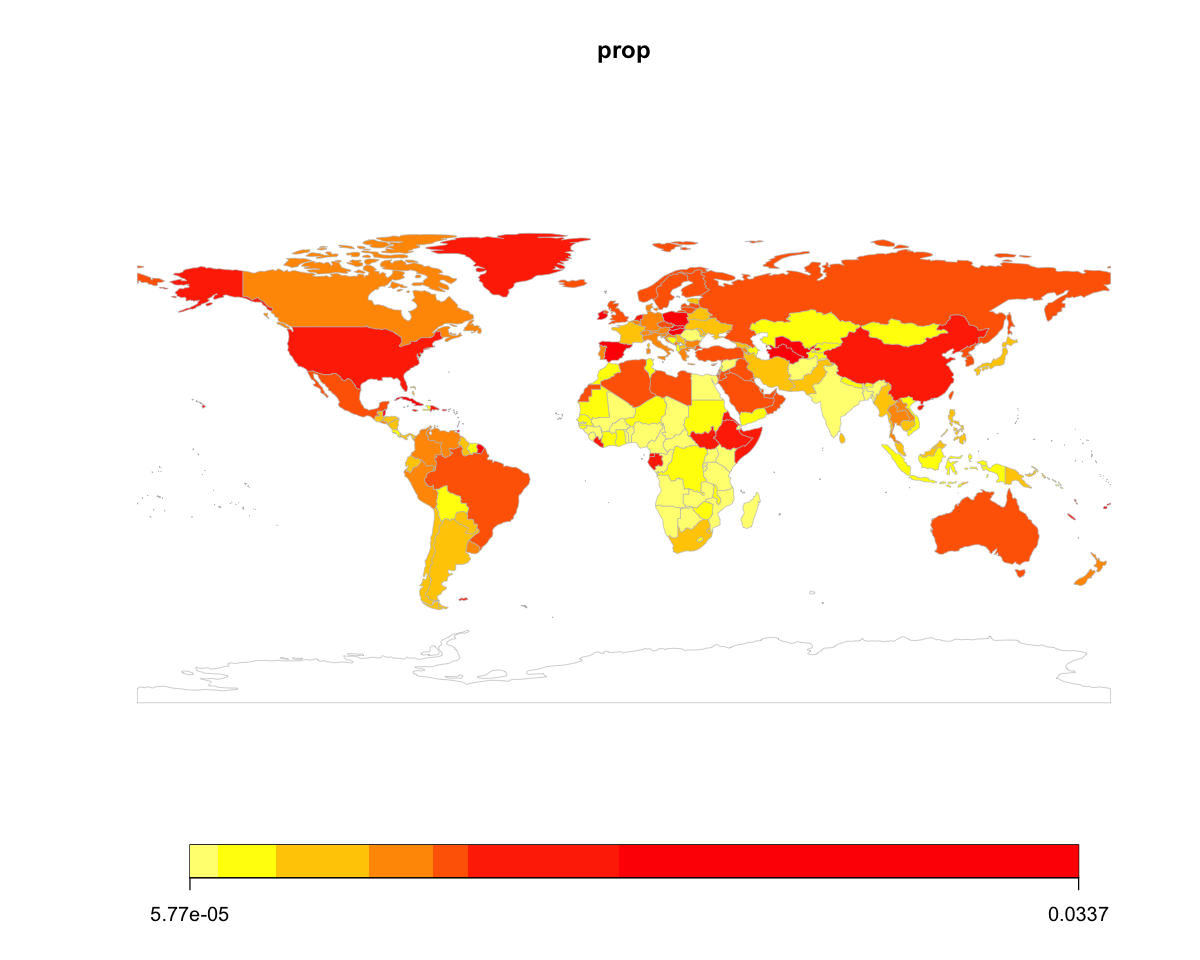

In [159]:
## checking with the figure for the proportion of MSM among total population
options(repr.plot.width=10,repr.plot.height=8)
df_MSM_imputed %>% dplyr::select(iso_code, prop) -> fig_MSM
Map = joinCountryData2Map(fig_MSM, joinCode = "ISO3", nameJoinColumn ="iso_code", mapResolution = "coarse") 
mapCountryData(Map, nameColumnToPlot="prop")

In [160]:
## applying a 14-day moving average for the newly reported and cumulative case counts
df_all_inci %>% group_by(location) %>% arrange(date) %>%
mutate(MA_new_cases = zoo::rollmean(new_cases, k=14, align="right", fill=NA),
       MA_total_cases = zoo::rollmean(total_cases, k=14, align="right", fill=NA)) -> temp
temp$MA_new_cases[is.na(temp$MA_new_cases)]<-0; temp$MA_total_cases[is.na(temp$MA_total_cases)]<-0; 

temp %<>% mutate(MA_new_cases=case_when(MA_new_cases<0 ~ 0, TRUE ~ MA_new_cases),
                 MA_total_cases=case_when(MA_total_cases<0 ~ 0, TRUE ~ MA_total_cases))

## calculating the cumlative incidence proportion (i.e., cumulative incidecne/MSM population)
temp %>% rename(MSM_pop=imputed) %>% mutate(MSM_pop=MSM_pop*1000) %>% 
group_by(location) %>% mutate(cum_icni_prop=MA_total_cases/(MSM_pop)) %>%
dplyr::select(iso_code, location, region, sub_region, date, new_cases, total_cases, MA_new_cases, MA_total_cases,
              date_import, MSM_pop, pop2022, cum_icni_prop) %>%
filter(date >= time_0) -> df_inci_MA

In [161]:
write.csv(df_inci_MA, "../data/df_inci_final_WHO_backproj.csv")

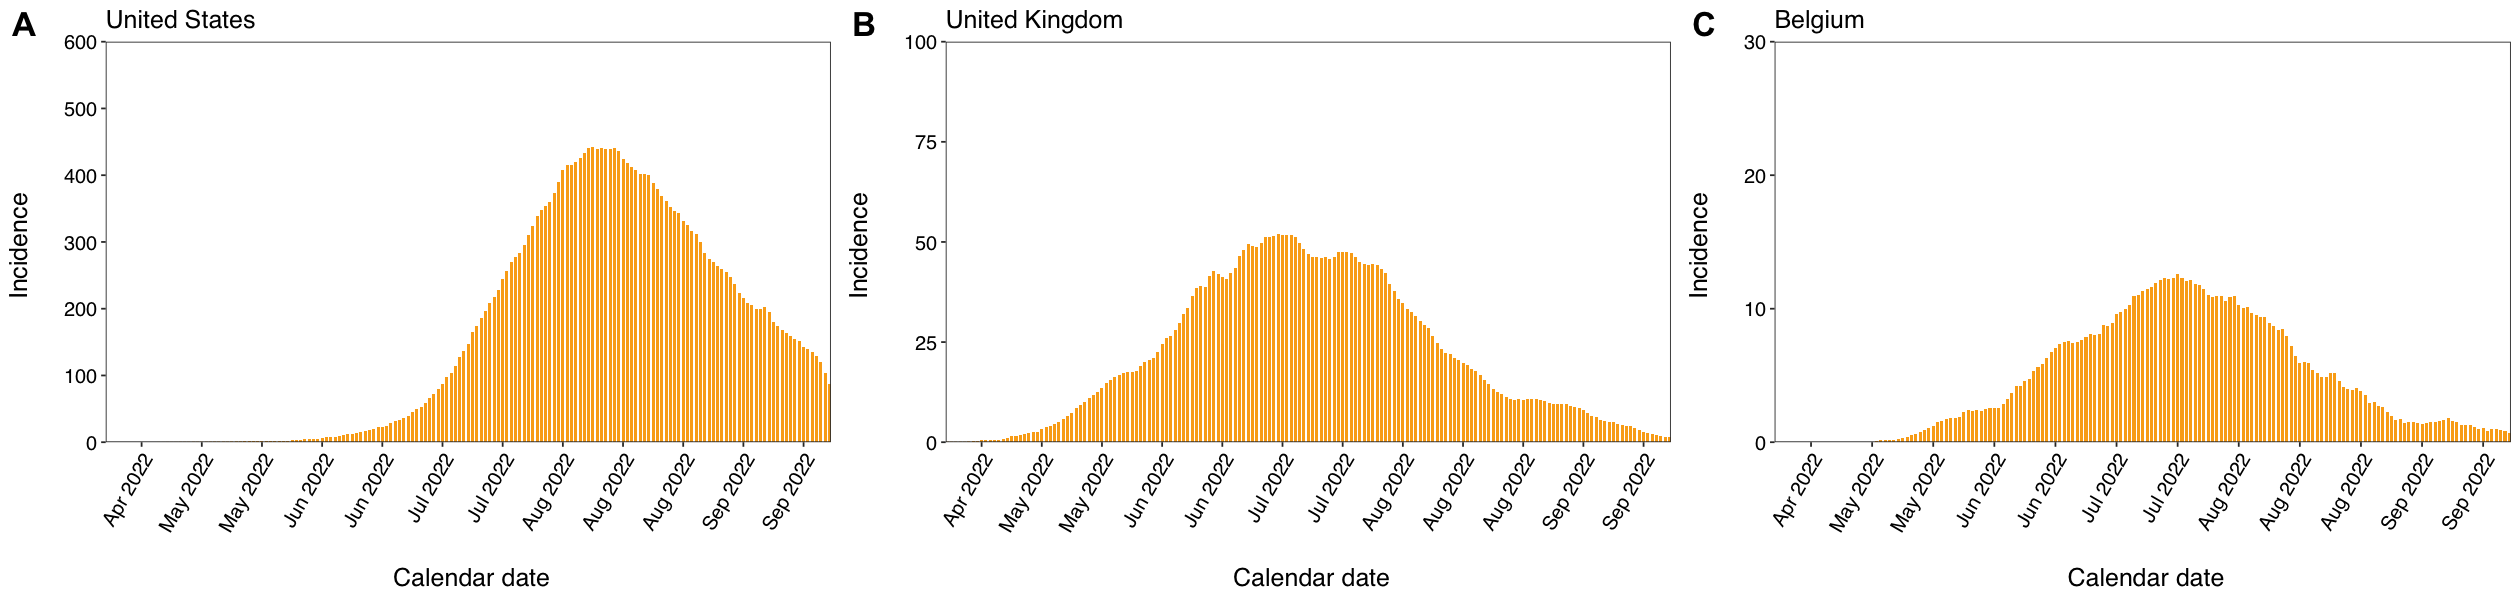

In [162]:
## checking the smoothened incidence with the 14-day moving average
options(repr.plot.width=7,repr.plot.height=5)
df_inci_MA %>% filter(iso_code==c("USA")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("United States") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,600)) -> Fig1

df_inci_MA %>% filter(iso_code==c("GBR")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("United Kingdom") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,100)) -> Fig2

df_inci_MA %>% filter(location==c("Belgium")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("Belgium") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,30)) -> Fig3

options(repr.plot.width=21,repr.plot.height=5)
ggarrange(Fig1, Fig2, Fig3, ncol = 3, nrow = 1, labels = c("A", "B", "C"), font.label = list(size = 20))

In [163]:
library(lubridate)
bimonthly <- function(x) {
  x_range <- range(x, na.rm = TRUE)
  
  date_range <- c(
    floor_date(x_range[1], "month"),
    ceiling_date(x_range[2], "month")
  )
  monthly <- seq(date_range[1], date_range[2], by = "1 month")
  
  sort(c(monthly, monthly + days(14)))
}

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_count()`).”


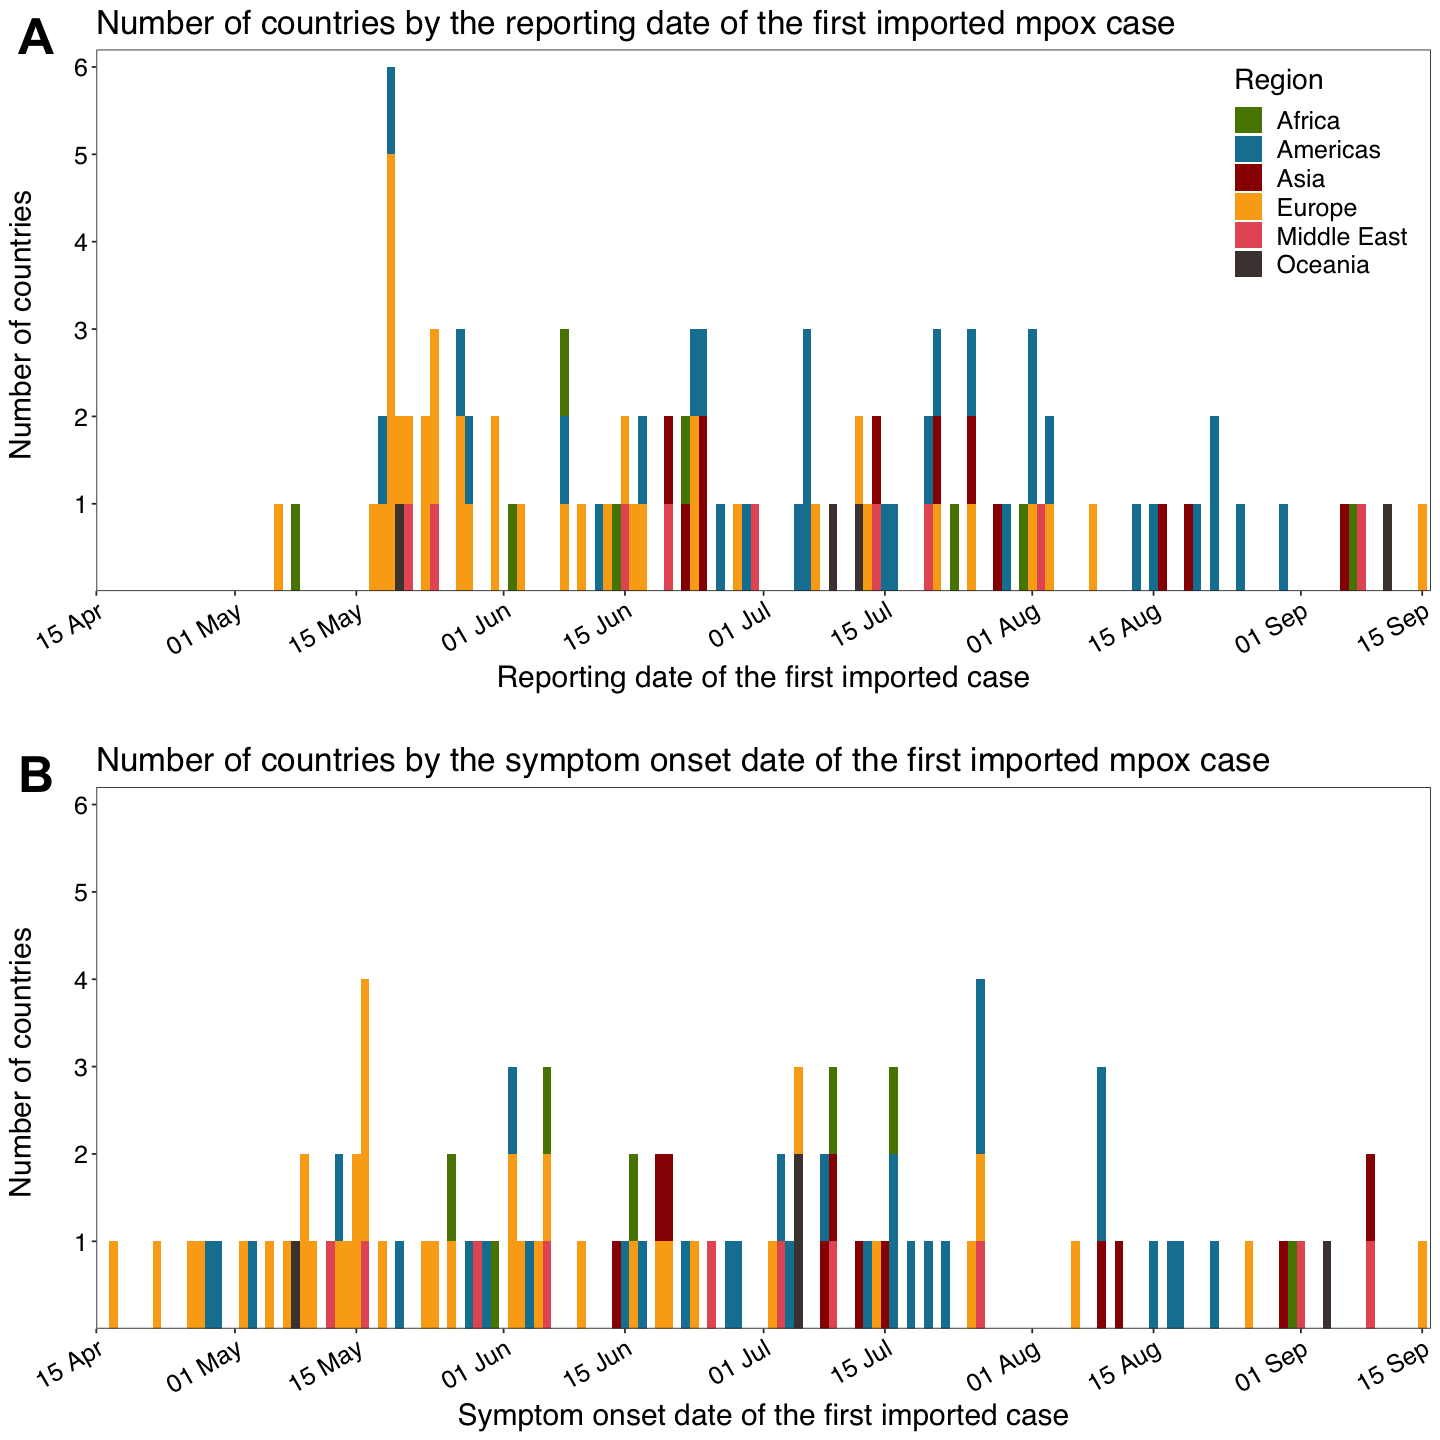

In [164]:
#### Discriptive figure

## with the reporting date
read.csv("../data/incidence/df_inci_Github.csv") %>% arrange(Country, Date) %>% 
mutate(date_import_adj=case_when(iso_code==c("CHN")~ as.Date("2022-06-24"), TRUE~as.Date(date_import))) %>%
dplyr::select(Country, iso_code, date_import_adj) %>% rename(date_import=date_import_adj) %>% 
distinct() -> df_reporting

df_inci_MA %>% ungroup() %>% 
mutate(region_adj = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
dplyr::select(region_adj, iso_code) %>% rename(region=region_adj) %>% distinct() -> temp

merge(df_reporting, temp, by=c("iso_code")) -> df_fig
as.Date(df_fig$date_import) -> df_fig$date_import
df_fig$region <- factor(df_fig$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig %>% filter(date_import >= as.Date("2022-04-15")), aes(x = date_import, fill = region)) +
geom_bar(width=1) +
scale_fill_viridis_d(direction = 1) +
# scale_fill_brewer("Region", palette="Dark2") +
scale_fill_manual("Region", values = c("#588300", "#1380A1", "#990000", "#FAAB18", "#E75B64FF", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x=element_text(angle=30, hjust=1),
      legend.position = c(.99, .99),
      legend.justification = c("right", "top"), legend.box.just = "right", legend.margin = margin(6, 6, 6, 6)) +
xlab("Reporting date of the first imported case") +
ylab("Number of countries \n") +
ggtitle("Number of countries by the reporting date of the first imported mpox case") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(df_fig$date_import)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(1,2,3,4,5,6)) +
coord_cartesian(ylim = c(0,6.2)) -> Fig1


## with the symptom onset date
df_inci_MA %>% 
mutate(region_adj = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
dplyr::select(location, region_adj, iso_code, date_import) %>% rename(region=region_adj) %>% distinct() -> df_fig2

df_fig2$region <- factor(df_fig2$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig2 %>% filter(date_import >= as.Date("2022-04-15")), aes(x = date_import, fill = region)) +
geom_bar(width=1) +
scale_fill_viridis_d(direction = 1) +
# scale_fill_brewer("Region", palette="Dark2") +
scale_fill_manual(values = c("#588300", "#1380A1", "#990000", "#FAAB18", "#E75B64FF", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Symptom onset date of the first imported case") +
ylab("Number of countries \n") +
ggtitle("Number of countries by the symptom onset date of the first imported mpox case") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(df_fig$date_import)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(1,2,3,4,5,6)) +
coord_cartesian(ylim = c(0,6.2)) -> Fig2

options(repr.plot.width=12,repr.plot.height=12)
ggarrange(Fig1, ggplot() + theme_void(), Fig2, ncol = 1, heights = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30))

ggsave("../figures/descriptive.png", width = 12, height = 12)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 12 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 6 rows containing missing values (`geom_bar()`).”


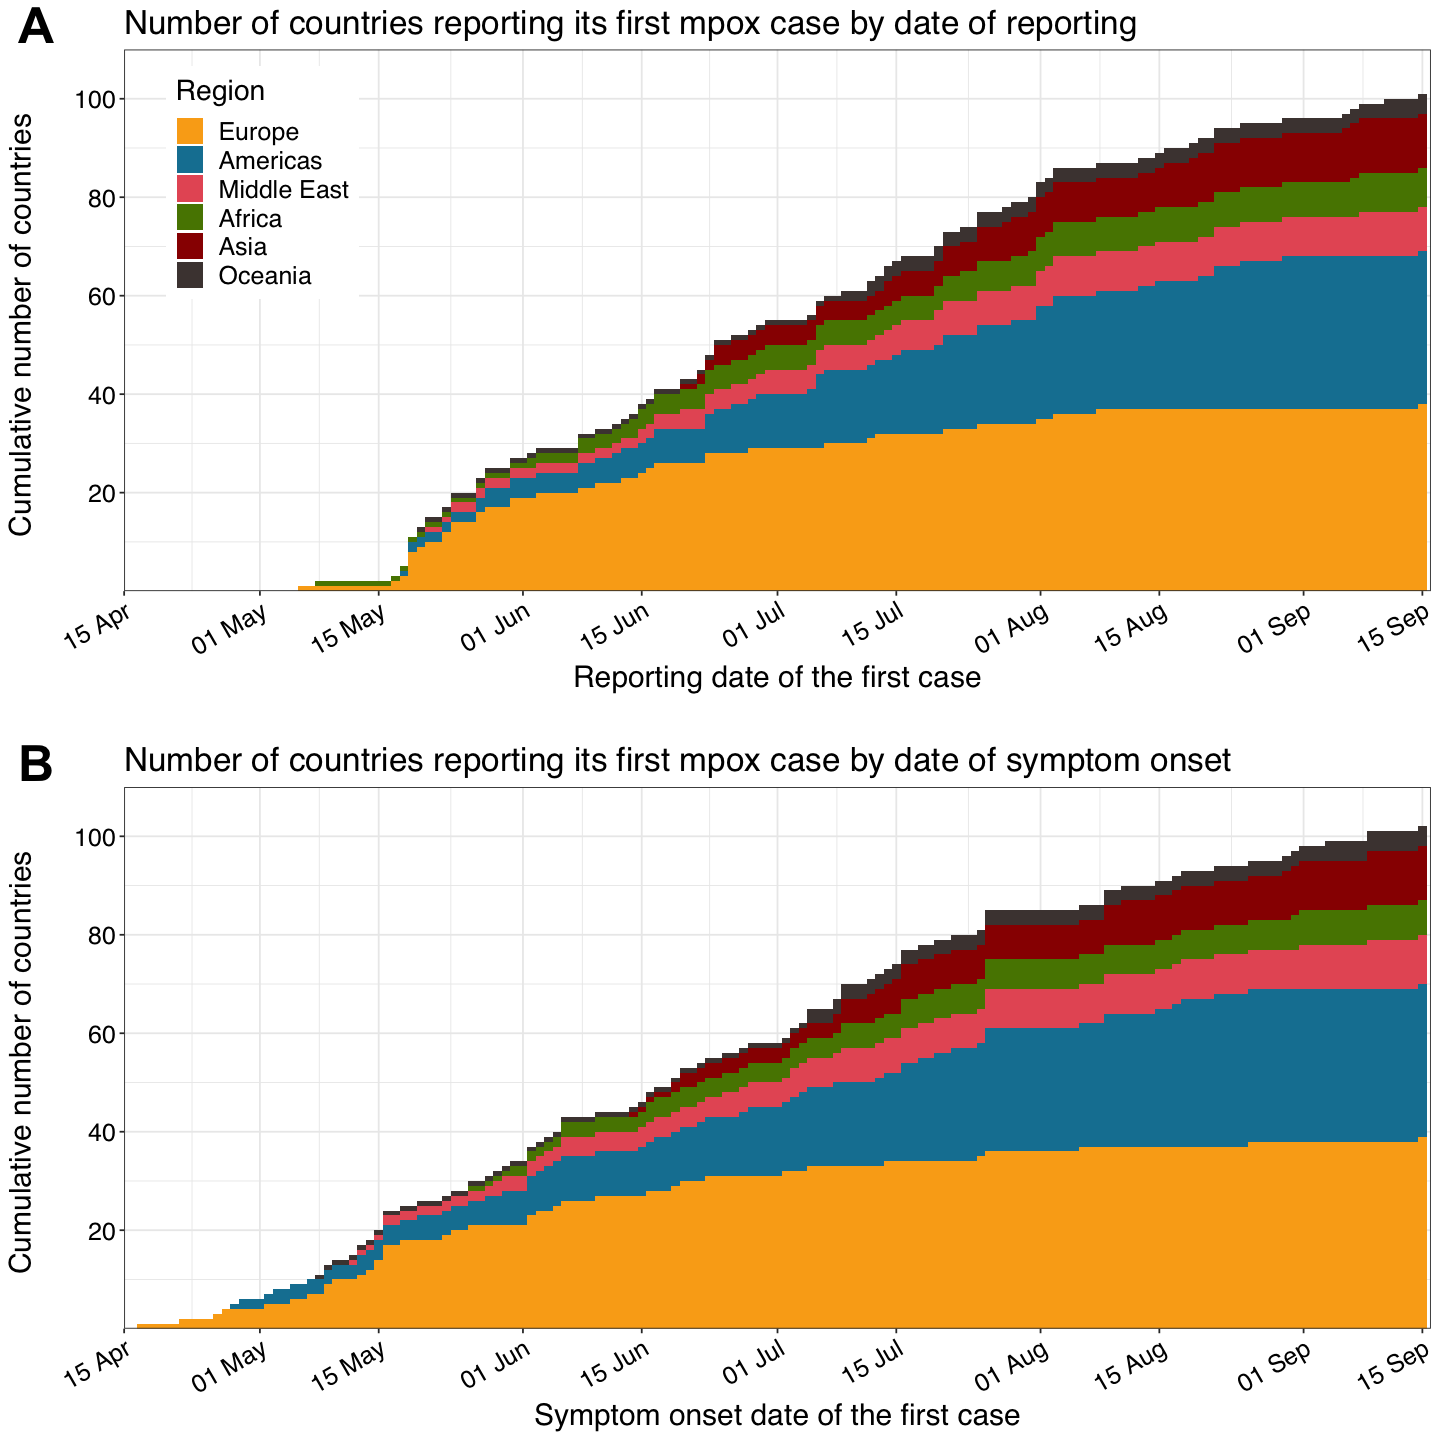

In [165]:
read.csv("../data/incidence/df_inci_Github.csv") %>% arrange(Country, Date) %>% 
mutate(date_import_adj=case_when(iso_code==c("CHN")~ as.Date("2022-06-24"), TRUE~as.Date(date_import))) %>%
dplyr::select(Country, iso_code, date_import_adj) %>% rename(date_import=date_import_adj) %>% 
distinct() -> df_reporting

df_inci_MA %>% ungroup() %>% 
mutate(region_adj = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
dplyr::select(region_adj, iso_code) %>% rename(region=region_adj) %>% distinct() -> temp

merge(df_reporting, temp, by=c("iso_code")) -> df_fig
as.Date(df_fig$date_import) -> df_fig$date_import
df_fig$region <- factor(df_fig$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

df_fig %>% filter(date_import >= as.Date("2022-04-15")) %>% dplyr::count(date_import, region) -> temp
as.data.frame(rep(seq(min(temp$date_import), max(temp$date_import), 1), each=6)) -> temp2
colnames(temp2) <- ("date_import")
temp2 %<>% mutate(region=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(temp$date_import), max(temp$date_import), 1))))
merge(temp2, temp, by=c("date_import", "region"), all.x=TRUE) -> df_fig_cum
df_fig_cum[is.na(df_fig_cum)] <-0
df_fig_cum %<>% group_by(region) %>% mutate(count=cumsum(n)) %>% ungroup() 

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig_cum, aes(x = date_import, y=count, fill = fct_reorder(region, count))) +
geom_bar(stat="identity", width=1) +
scale_fill_viridis_d(direction = 1) +
# scale_fill_brewer("Region", palette="Dark2") +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
#       panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x=element_text(angle=30, hjust=1),
      legend.position = c(0.18, .97),
      legend.justification = c("right", "top"), legend.box.just = "left", legend.margin = margin(6, 6, 6, 6)) +
xlab("Reporting date of the first case") +
ylab("Cumulative number of countries \n") +
ggtitle("Number of countries reporting its first mpox case by date of reporting") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(df_fig$date_import)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20,40,60,80,100)) +
coord_cartesian(ylim = c(0,110)) -> Fig1


## with the symptom onset date
df_inci_MA %>% ungroup() %>%
mutate(region_adj = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
dplyr::select(location, region_adj, iso_code, date_import) %>% rename(region=region_adj) %>% distinct() -> df_fig2

df_fig2$region <- factor(df_fig2$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

df_fig2 %>% filter(date_import >= as.Date("2022-04-15")) %>% dplyr::count(date_import, region) -> temp
as.data.frame(rep(seq(min(temp$date_import), max(temp$date_import), 1), each=6)) -> temp2
colnames(temp2) <- ("date_import")
temp2 %<>% mutate(region=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(temp$date_import), max(temp$date_import), 1))))
merge(temp2, temp, by=c("date_import", "region"), all.x=TRUE) -> df_fig_cum2
df_fig_cum2[is.na(df_fig_cum2)] <-0
df_fig_cum2 %<>% group_by(region) %>% mutate(count=cumsum(n)) %>% ungroup() 

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig_cum2, aes(x = date_import, y=count, fill = fct_reorder(region, count))) +
geom_bar(stat="identity", width=1) +
scale_fill_viridis_d(direction = 1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      #panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Symptom onset date of the first case") +
ylab("Cumulative number of countries \n") +
ggtitle("Number of countries reporting its first mpox case by date of symptom onset") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), max(df_fig$date_import)), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20,40,60,80,100)) +
coord_cartesian(ylim = c(0,110)) -> Fig2

options(repr.plot.width=12,repr.plot.height=12)
ggarrange(Fig1, ggplot() + theme_void(), Fig2, ncol = 1, heights = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30), vjust=1.2)

ggsave("../figures/final_figures/Fig1.png", width = 12, height = 12, dpi=600)

In [166]:
setdiff(df_fig$iso_code, df_fig2$iso_code)
setdiff(df_fig2$iso_code, df_fig$iso_code)

character(0)

[1] "SMR" "VNM"

In [167]:
library(MazamaSpatialUtils)

read.csv("../data/WHO-COVID-19-global-data.csv") -> df_covid
df_covid$Date_reported <- as.Date(df_covid$Date_reported)

df_covid %<>% filter(Cumulative_cases > 0) %>% group_by(Country) %>% arrange(Date_reported) %>% slice(1L) %>% 
ungroup() %>% mutate(First_date=as.Date("2020-01-04")) %>%
filter(!(Country==c("Other"))) %>%
mutate(diff=log(as.numeric(Date_reported-First_date)), iso_code=iso2ToIso3(Country_code))

merge(df_covid, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("Republic of Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran (Islamic Republic of)")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela (Bolivarian Republic of)")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia (Plurinational State of)")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         TRUE~Country)) -> df_covid

Warning message in countrycode_convert(sourcevar = sourcevar, origin = origin, destination = dest, :
“Some values were not matched unambiguously: XA, XB, XC, XK
”


In [168]:
read.csv("../data/incidence/Github.csv") -> df_mpox
df_mpox$Date <- as.Date(df_mpox$Date)
max(df_mpox$Date)

df_mpox %<>% filter(Cumulative_cases > 0) %>% group_by(Country) %>% arrange(Date) %>% slice(1L) %>% 
ungroup() %>% filter(Date >= as.Date("2022-05-01")) %>%
filter(!Country %in% c("Ghana", "Liberia", "Congo", "Nigeria", "Cameroon", 
                       "Democratic Republic Of The Congo", "Central African Republic")) %>%
mutate(Country=case_when(Country==c("Hong Kong")~c("China"),
                         Country==c("Taiwan")~c("China"),
                         TRUE~Country)) %>%
group_by(Country) %>% arrange(Date) %>% slice(1L) %>% ungroup()

read.csv("../data/incidence/df_inci_Github.csv") -> df_mpox_iso
df_mpox_iso %<>% dplyr::select(Country, iso_code) %>% distinct()

merge(df_mpox, df_mpox_iso, by=c("Country"), all.x=TRUE) -> df_mpox

merge(df_mpox, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("South Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         Country==c("Czech Republic")~c("Czechia"),
                         Country==c("Moldova")~c("Moldova, Republic of"),
                         Country==c("Bosnia And Herzegovina")~c("Bosnia and Herzegovina"),
                         Country==c("Russia")~c("Russian Federation"),
                         Country==c("United States")~c("United States of America"),
                         TRUE~Country)) %>% rename(Date_reported = Date) -> df_mpox

max(df_mpox$Date_reported)-min(df_mpox$Date_reported)+1

[1] "2022-09-23"

Time difference of 134 days

In [169]:
df_covid %>% filter(Date_reported <= min(df_covid$Date_reported)+134) -> df_covid_fig

setdiff(df_covid_fig$Country, df_mpox$Country) -> list_country; 
list_country <- list_country[1:(length(list_country)-1)]
df_covid %>% filter(Country %in% list_country) %>% 
dplyr::select(iso_code, Country, region, sub_region, group) %>% 
mutate(Date_reported=as.Date("2022-12-31"), Cases=0, Cumulative_cases=0) -> df_mpox_add

rbind(df_mpox_add, df_mpox) -> df_mpox_all

df_mpox_all %>% nrow()
df_covid_fig %>% nrow()

[1] 212

[1] 212

In [170]:
options(repr.plot.width=13,repr.plot.height=30)

ggplot() +
geom_point(data=df_covid_fig, 
           aes(x=reorder(Country,Date_reported), y=Date_reported, color=group), size=4) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="", y="\n Arrival date of COVID-19") +
ggtitle("Arrival time of COVID-19 by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=13, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> covid_dateimp

Warning message:
“Removed 112 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 112 rows containing missing values (`geom_point()`).”


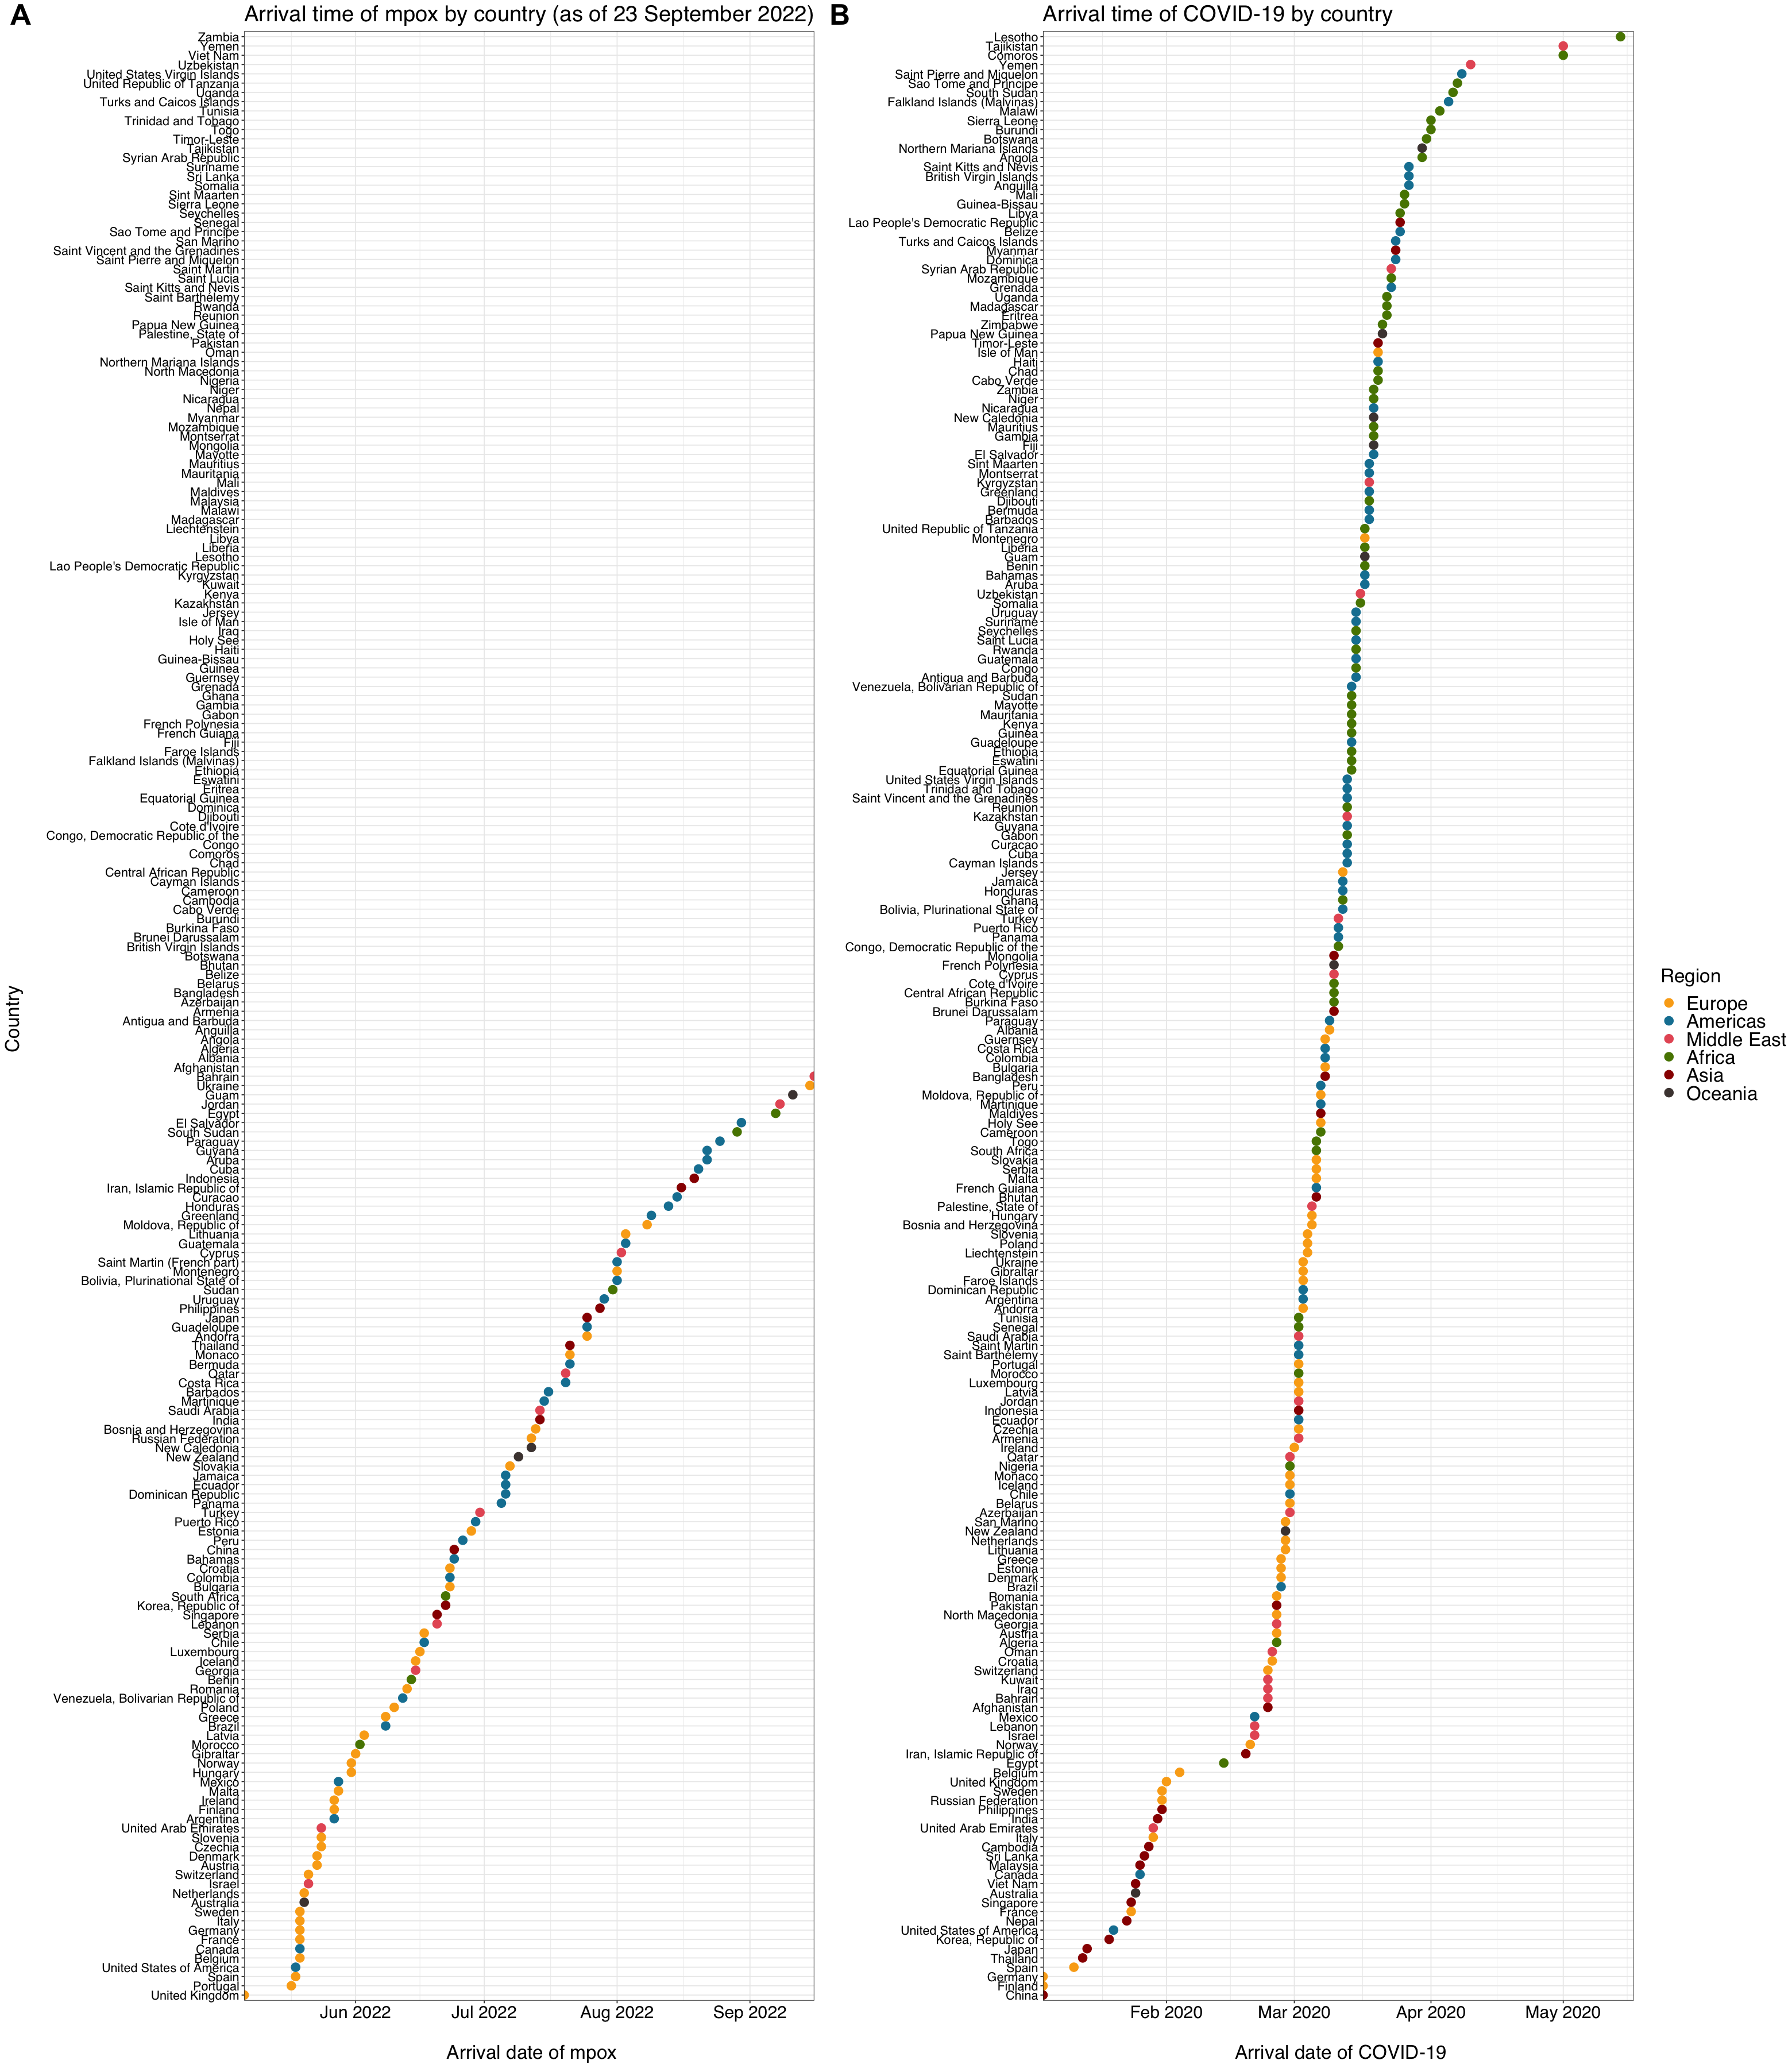

In [171]:
ggplot() +
geom_point(data=df_mpox_all, 
           aes(x=reorder(Country,Date_reported), y=Date_reported, color=group), size=4) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="Country \n", y="\n Arrival date of mpox") +
ggtitle("Arrival time of mpox by country (as of 23 September 2022)") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=13, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), max(df_mpox$Date_reported)), expand = c(0, 0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> mpox_dateimp

options(repr.plot.width=26,repr.plot.height=30)
ggarrange(mpox_dateimp, covid_dateimp, ggplot() + theme_void(), ncol = 3, widths = c(1, 1, 0.02),
          labels = c("A", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")
ggsave("../figures/final_figures/FigS5.png", width = 26, height = 30, dpi=600)